# PCA diff on hic data
take patient and control data from dlbcl. apply pca on them for some window size. take the difference of these transformed matrices.

## imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import fanc
import fanc.plotting
from scipy import ndimage as ndi
import matplotlib.patches as patches
from scipy.ndimage import zoom
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import seaborn as sns
from sklearn.decomposition import PCA
import math

## define functions

In [2]:
def clipped_zoom(img, zoom_factor, **kwargs):
    h, w = img.shape[:2]
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)
    if zoom_factor < 1:
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)
    elif zoom_factor > 1:
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2
        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]
    else:
        out = img
    return out

def highlight_features(dataframe, region, color, a, axes):
    try:
        features = dataframe.loc[region].values.tolist()
        if type(features[0]) == int:
            _, x_min, x_max, y_min, y_max = features
            rect = patches.Rectangle((x_min,y_min),x_max-x_min,y_max-y_min,linewidth=1.2,
                                     edgecolor=color, facecolor='none')
            axes[a].add_patch(rect)
        else:
            for f in features:
                _, x_min, x_max, y_min, y_max = f
                rect = patches.Rectangle((x_min,y_min),x_max-x_min,y_max-y_min,linewidth=1.2,
                                         edgecolor=color, facecolor='none')
                axes[a].add_patch(rect)
                
    except KeyError:
        next

def collect_windows(matrix, window_size):
    """ Extracts all sliding windows from the matrix for PCA. """
    m, n = matrix.shape
    windows = []

    for i in range(0, m - window_size + 1):
        for j in range(0, n - window_size + 1):
            window = matrix[i:i+window_size, j:j+window_size].flatten()
            windows.append(window)  # Collect all windows

    return np.array(windows)

def apply_pca(matrix, window_size, n_components=1):
    """
    Apply PCA to all windows in the matrix together, returning transformed features.
    """
    windows = collect_windows(matrix, window_size)  # Collect windows

    pca = PCA(n_components=n_components)
    transformed_windows = pca.fit_transform(windows)  # Apply PCA on all windows

    return transformed_windows.reshape(matrix.shape[0] - window_size + 1, 
                                       matrix.shape[1] - window_size + 1)

## load .hic data

In [3]:
winsize = "3mb"
wdir = "../data/dlbcl/"
region_pairs = "hg38_chr2_{}_win_100kb_step.bed".format(winsize)

gained = pd.read_csv(wdir + 'gained_features.tsv', delimiter=',', usecols=[0, 1, 2, 3, 4, 5], header=None, index_col=[0])
lost = pd.read_csv(wdir + 'lost_features.tsv', delimiter=',', usecols=[0, 1, 2, 3, 4, 5], header=None, index_col=[0])

regions = pd.read_csv(wdir + region_pairs, sep='\t', header=None)

patient_hic = fanc.load(wdir + "ukm_patient_fixed_le_25kb_chr2.hic")
control_hic = fanc.load(wdir + "ukm_control_fixed_le_25kb_chr2.hic")

reg = 1448

window_start, window_end = regions.loc[reg][1:3]

region_string = "chr2:{}-{}".format(window_start, window_end)

patient_region_sub = patient_hic[region_string, region_string].data
control_region_sub = control_hic[region_string, region_string].data

min_v = min(
    [
        np.min(np.extract(patient_region_sub>0 , patient_region_sub)),
        np.min(np.extract(control_region_sub>0 , control_region_sub))
    ]
)

patient_region_sub += min_v
control_region_sub += min_v
print("loaded hic")

loaded hic


## perform computations on matrices

In [4]:
# Set window size
# TODO add a while loop that will regenerate every time new window size entered
window_size = 3

# raw matrices
zm1 = clipped_zoom(patient_region_sub, 0.7)
rot_patient = ndi.rotate(zm1, 45, reshape=False)

zm2 = clipped_zoom(control_region_sub, 0.7)
rot_control = ndi.rotate(zm2, 45, reshape=False)

# Apply PCA
pca_matrix1 = apply_pca(patient_region_sub, window_size)
zm_pca1 = clipped_zoom(pca_matrix1, 0.7)
rot_pca1 = ndi.rotate(zm_pca1, 45, reshape=False)

pca_matrix2 = apply_pca(control_region_sub, window_size)
zm_pca2 = clipped_zoom(pca_matrix2, 0.7)
rot_pca2 = ndi.rotate(zm_pca2, 45, reshape=False)

# Compute PCA difference matrix (patient - control)
diff_pca = pca_matrix1 - pca_matrix2
zm_diff_pca = clipped_zoom(diff_pca, 0.7)
rot_diff_pca = ndi.rotate(zm_diff_pca, 45, reshape=False)

# subtract inverse (control - patient)
diff_pca2 = pca_matrix2 - pca_matrix1
zm_diff_pca2 = clipped_zoom(diff_pca2, 0.7)
rot_diff_pca2 = ndi.rotate(zm_diff_pca2, 45, reshape=False)

## generate plots

matrix size: 121 x 121
window size: 3
Plot saved to out/pca_hic.png


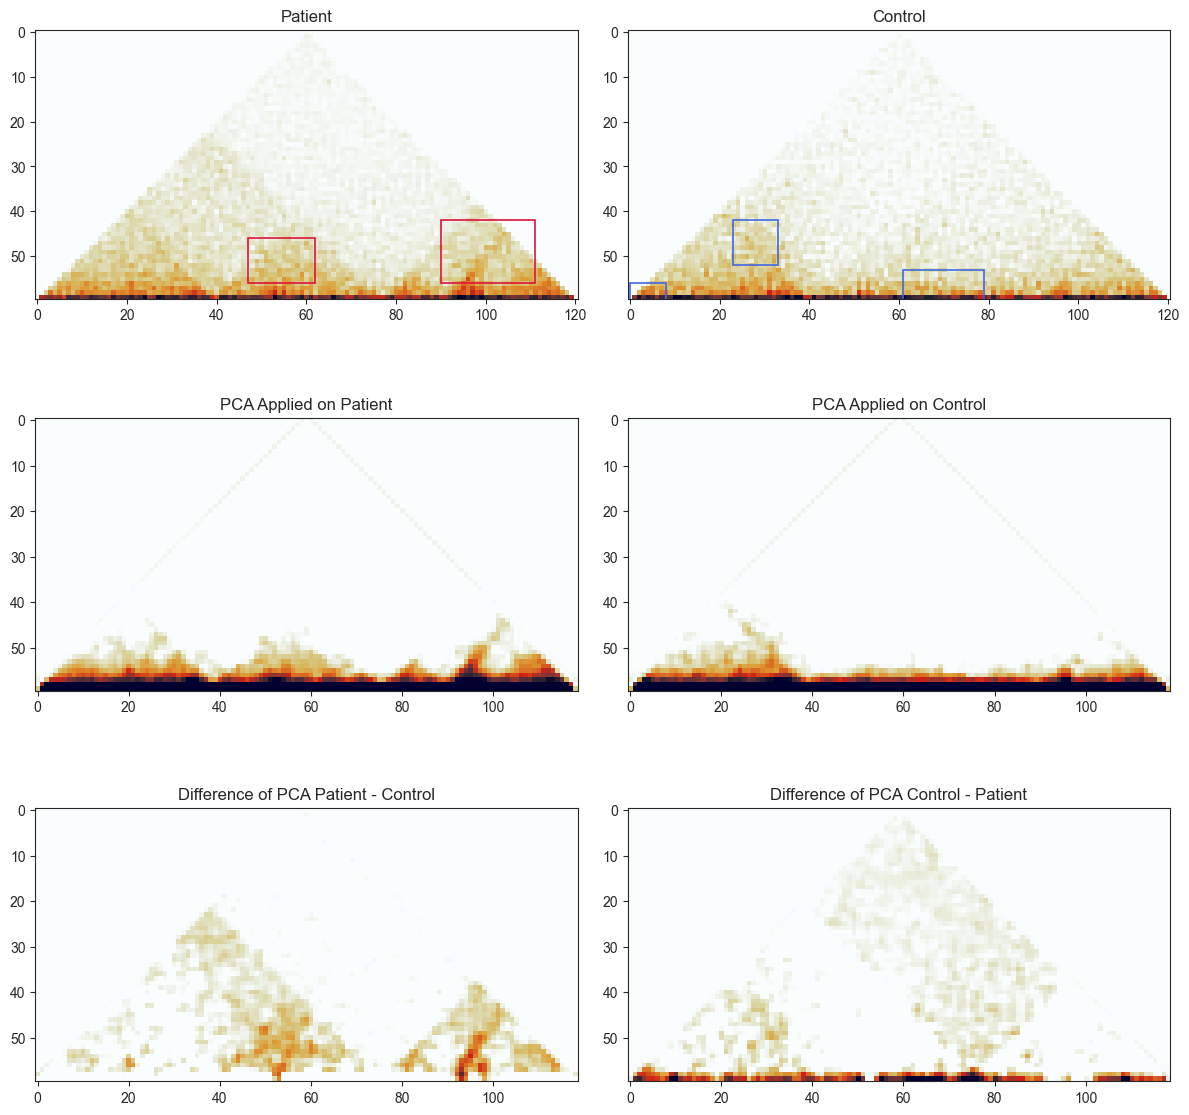

In [5]:
# Plot heatmaps in a grid layout
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

middle = int(np.shape(rot_control)[1]/ 2.)

# First row: Raw matrices
# per region check if identified features, to highlight
highlight_features(gained, reg, 'crimson', 0, axes[0])
highlight_features(lost, reg, 'royalblue', 1, axes[0])

# sns.heatmap(matrix1, cmap="coolwarm", ax=axes[0, 0])
print(f"matrix size: {len(rot_patient)} x {len(rot_patient[0])}")
print(f"window size: {window_size}")
m1 = axes[0][0].imshow(rot_patient[:middle, :], vmin=0, vmax=0.03, cmap='germany')
axes[0, 0].set_title("Patient")

# sns.heatmap(matrix2, cmap="coolwarm", ax=axes[0, 1])
m1 = axes[0][1].imshow(rot_control[:middle, :], vmin=0, vmax=0.03, cmap='germany')
axes[0, 1].set_title("Control")

# Second row: PCA transformed matrices
# sns.heatmap(pca_matrix1, cmap="coolwarm", ax=axes[1, 0])
m1 = axes[1][0].imshow(rot_pca1[:middle, :], vmin=0, vmax=0.03, cmap='germany')
axes[1, 0].set_title("PCA Applied on Patient")

# sns.heatmap(pca_matrix2, cmap="coolwarm", ax=axes[1, 1])
m1 = axes[1][1].imshow(rot_pca2[:middle, :], vmin=0, vmax=0.03, cmap='germany')
axes[1, 1].set_title("PCA Applied on Control")

# Third row: Difference matrix spanning two columns
# sns.heatmap(diff_matrix, cmap="coolwarm", ax=axes[2, 0], cbar=True)
m1 = axes[2][0].imshow(rot_diff_pca[:middle, :], vmin=0, vmax=0.03, cmap='germany')
axes[2, 0].set_title("Difference of PCA Patient - Control")

# sns.heatmap(matrix2_small_noise, cmap="coolwarm", ax=axes[2, 1], cbar=True)
m1 = axes[2][1].imshow(rot_diff_pca2[:middle, :], vmin=0, vmax=0.03, cmap='germany')
axes[2, 1].set_title("Difference of PCA Control - Patient")

# Adjust layout
plt.tight_layout()

# save plot
save_path = os.path.join("out", "pca_hic.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')  # High resolution and tight layout

print(f"Plot saved to {save_path}")